In [1]:
import warnings
warnings.filterwarnings(
    action='ignore',
    category=FutureWarning
)

In [2]:
import os

import FACSPy as fp
import scanpy as sc

import figure_config as cfg

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec

from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from matplotlib import colors

In [4]:
nk_cells = fp.read_dataset(cfg.data_input, "dataset_NK_preprocessed")
nk_cells.uns["metadata"].dataframe["group"] = nk_cells.uns["metadata"].dataframe["diag_main"]

set1_colors = sns.color_palette("Set1")[0:2]
nk_cells.uns["organ_colors"] = [colors.to_hex(color) for color in set1_colors]
set2_colors = sns.color_palette("Set2")[0:3]
nk_cells.uns["organ_diag_colors"] = [colors.to_hex(color) for color in set2_colors]

In [5]:
df = nk_cells.to_df(layer = "transformed")
df[nk_cells.obs.columns] = nk_cells.obs

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's', 'edgecolor'
  cset = contour_func(


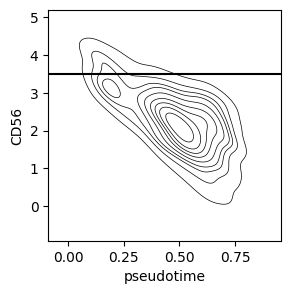

In [24]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (3,3))
sns.kdeplot(data = df.sample(frac = 0.05), x = "pseudotime", y = "CD56", s = 4, edgecolor = "black", color = "black", linewidths = 0.5, ax = ax)
ax.axhline(y = 3.5, color = "black")
plt.show()

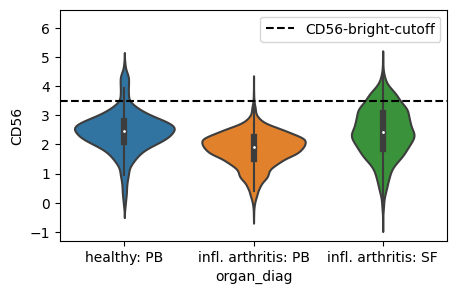

In [35]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5,3))
sns.violinplot(data = df, x = "organ_diag", y = "CD56", ax = ax)
ax.axhline(y = 3.5, color = "black", linestyle = "--", label = "CD56-bright-cutoff")
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.2)
ax.legend()
plt.show()

In [9]:
df["CD56_bright"] = False
df.loc[df["CD56"] > 3.5, "CD56_bright"] = True

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

healthy: PB vs. infl. arthritis: PB: Mann-Whitney-Wilcoxon test two-sided, P_val:8.662e-04 U_stat=6.300e+01
infl. arthritis: PB vs. infl. arthritis: SF: Mann-Whitney-Wilcoxon test two-sided, P_val:9.419e-03 U_stat=4.500e+00
healthy: PB vs. infl. arthritis: SF: Mann-Whitney-Wilcoxon test two-sided, P_val:5.964e-01 U_stat=2.600e+01


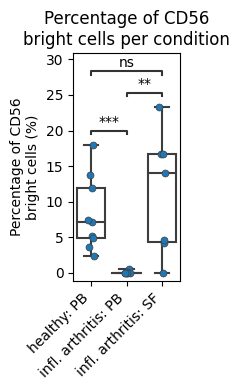

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Step 1: Calculate percentage of CD56_bright per sample and organ_diag
percentages_df = (
    df.groupby(['organ_diag', 'sample_ID'])
      .agg(
          total_cells=('CD56_bright', 'count'),
          bright_cells=('CD56_bright', lambda x: (x == True).sum())
      )
      .reset_index()
)

percentages_df['bright_percent'] = (percentages_df['bright_cells'] / percentages_df['total_cells']) * 100

# Step 2: Prepare the plot
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (2,4))
sns.boxplot(
    data=percentages_df,
    x='organ_diag',
    y='bright_percent',
    ax = ax,
    boxprops = dict(facecolor = "white"),
    whis = (0,100)
)

sns.stripplot(
    data=percentages_df,
    x='organ_diag',
    y='bright_percent',
    jitter=True,
    dodge=True,
    linewidth = 0.5,
    ax = ax
)

# Step 3: Define comparisons for statistical testing
# Generate all pairwise comparisons automatically:
from itertools import combinations

organ_conditions = percentages_df['organ_diag'].unique()
pairs = list(combinations(organ_conditions, 2))

# Step 4: Add statistical annotations with statannotations
annotator = Annotator(ax, pairs, data=percentages_df, x='organ_diag', y='bright_percent')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
annotator.apply_and_annotate()

# Customize plot
ax.set_title('Percentage of CD56\nbright cells per condition')
ax.set_ylabel('Percentage of CD56\nbright cells (%)')
ax.set_xticklabels(ax.get_xticklabels(), ha = "right", rotation = 45)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

C:\Users\tarik\AppData\Local\Temp\ipykernel_38044\3352347024.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cd56_plot.set_xticklabels(cd56_plot.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
C:\Users\tarik\AppData\Local\Temp\ipykernel_38044\3352347024.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  cd56_plot.set_yticklabels(cd56_plot.get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
C:\Users\tarik\AppData\Local\Temp\ipykernel_38044\3352347024.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  cd16_plot.set_xticklabels(cd16_plot.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
C:\Users\tarik\AppData\Local\Temp\ipykernel_38044\3352347024.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cd16_plot.set_yticklabels(cd16_plot.get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
C:\Users\tarik\AppData\Local\Temp\ipykernel_38044\3352347024.py:48: User

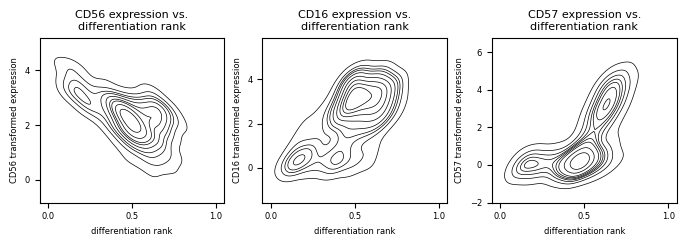

In [8]:
#################
### FIGURE S3 ###
#################

fig = plt.figure(layout = "constrained", figsize = (cfg.FIGURE_WIDTH_FULL, cfg.FIGURE_HEIGHT_HALF / 2))
gs = gridspec.GridSpec(ncols = 3,
                       nrows = 1,
                       figure = fig)
plot_params = {
    "data": df.sample(frac = 0.05),
    "x": "pseudotime",
    "color": "black",
    "linewidths": 0.5
    
}

cd56_plot = fig.add_subplot(gs[0])
sns.kdeplot(y = "CD56",
            ax = cd56_plot,
            **plot_params)
cd56_plot.set_title("CD56 expression vs.\ndifferentiation rank", fontsize = cfg.TITLE_SIZE)
cd56_plot.set_xlabel("differentiation rank", fontsize = cfg.AXIS_LABEL_SIZE)
cd56_plot.set_ylabel("CD56 transformed expression", fontsize = cfg.AXIS_LABEL_SIZE)
cd56_plot.set_xticklabels(cd56_plot.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
cd56_plot.set_yticklabels(cd56_plot.get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
cd56_plot.set_xlim(-0.05, 1.05)


cd16_plot = fig.add_subplot(gs[1])
sns.kdeplot(y = "CD16",
            ax = cd16_plot,
            **plot_params)
cd16_plot.set_title("CD16 expression vs.\ndifferentiation rank", fontsize = cfg.TITLE_SIZE)
cd16_plot.set_xlabel("differentiation rank", fontsize = cfg.AXIS_LABEL_SIZE)
cd16_plot.set_ylabel("CD16 transformed expression", fontsize = cfg.AXIS_LABEL_SIZE)
cd16_plot.set_xticklabels(cd16_plot.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
cd16_plot.set_yticklabels(cd16_plot.get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
cd16_plot.set_xlim(-0.05, 1.05)


cd57_plot = fig.add_subplot(gs[2])
sns.kdeplot(y = "CD57",
            ax = cd57_plot,
            **plot_params)
cd57_plot.set_title("CD57 expression vs.\ndifferentiation rank", fontsize = cfg.TITLE_SIZE)
cd57_plot.set_xlabel("differentiation rank", fontsize = cfg.AXIS_LABEL_SIZE)
cd57_plot.set_ylabel("CD57 transformed expression", fontsize = cfg.AXIS_LABEL_SIZE)
cd57_plot.set_xticklabels(cd57_plot.get_xticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
cd57_plot.set_yticklabels(cd57_plot.get_yticklabels(), fontsize = cfg.AXIS_LABEL_SIZE)
cd57_plot.set_xlim(-0.05, 1.05)


plt.savefig(f"{cfg.figure_output}FigureS4.pdf", dpi = 300, bbox_inches ="tight")
plt.show()
    